In [1]:
import pandas as pd
import numpy as np

import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_name = 'Cortical Area Development_20862356'

In [3]:
attractor_path = '/home/spankaew/Git/astrologics/data/attractor_group/calculated_attractor/' + model_name + '_attractors.csv'
attractor_data = pd.read_csv(attractor_path, index_col = 0)

In [4]:
model_path = '/home/spankaew/Git/astrologics/inferred_model/' + model_name  + '/'
model = le.LogicEnsemble(model_path, project_name = 'test')
model.create_simulation()

Simulation object created


In [5]:
simulation_path = '/home/spankaew/Git/astrologics/data/simulation_files/' + model_name + '_simulation.csv'
model.simulation.simulation_df = pd.read_csv(simulation_path, index_col = 0)

In [6]:
model.create_trajectory()
model.trajectory.calculate_distancematrix(mode = 'trajectory')

Trajectory object created
Calculating distance matrix for whole trajectory...


100%|██████████| 1000/1000 [01:00<00:00, 16.60it/s]

Distance matrix calculated successfully.


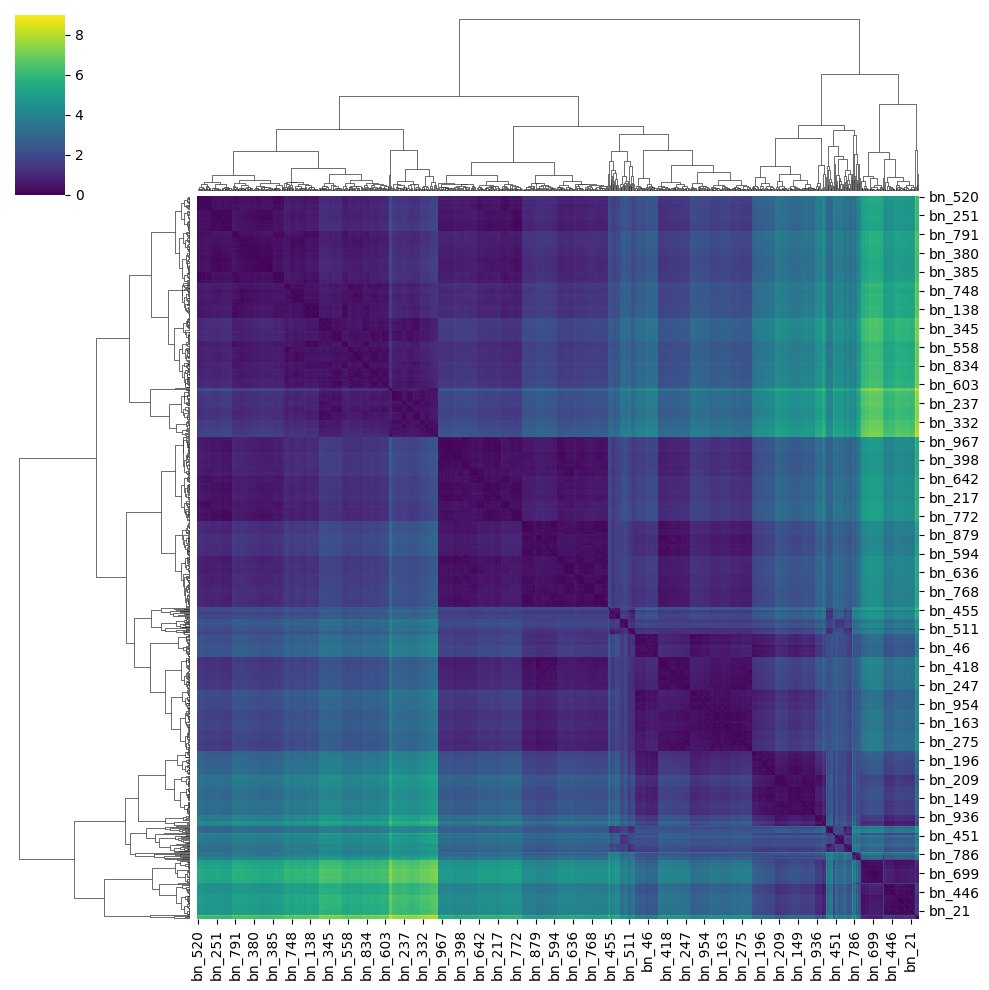

In [12]:
sns.clustermap(model.trajectory.distance_matrix, cmap='viridis', figsize=(10, 10))

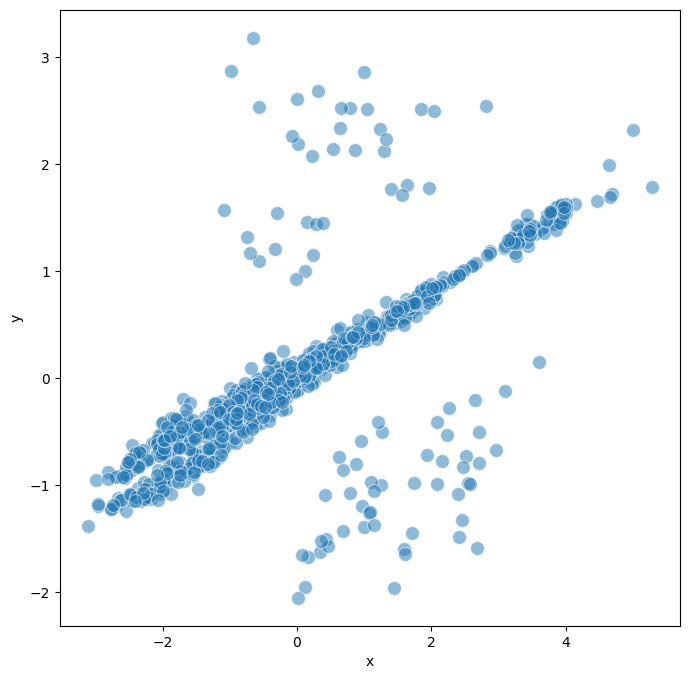

In [7]:
# Perform MDS (Multidimensional Scaling) for visualization
model.trajectory.calculate_MDS()
model.trajectory.plot_MDS(s = 100, fig_size = (8,8))

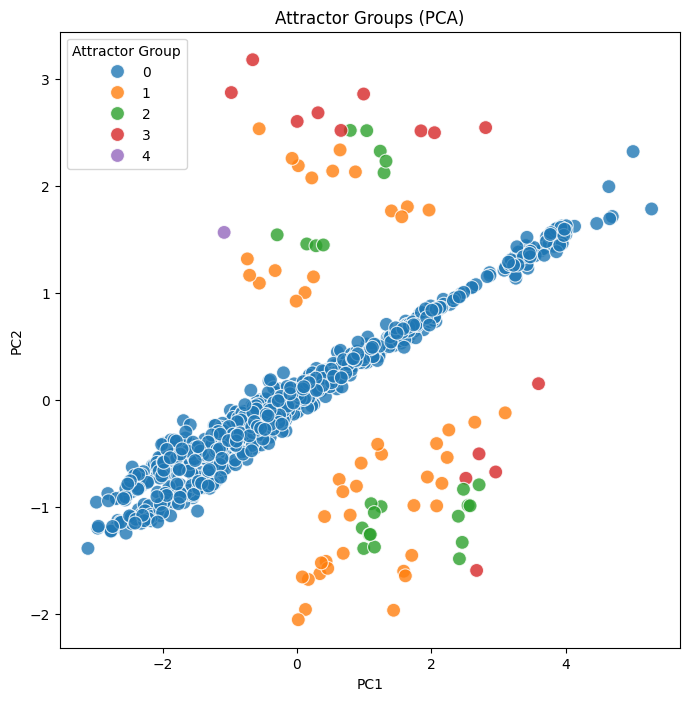

In [8]:
attractor_group_path = '/home/spankaew/Git/astrologics/data/attractor_group/attractor_group/' + model_name + '_attractor_group.csv'
attractor_group = pd.read_csv(attractor_group_path, index_col = 0)
attractor_group_dict = attractor_group['attractor_group'].to_dict()


coords = model.trajectory.mds_coords
coords['attractor_group'] = coords.index.map(attractor_group_dict)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=coords['x'],
    y=coords['y'],
    hue=coords['attractor_group'],
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.legend(title="Attractor Group")
plt.grid(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Attractor Groups (PCA)')
plt.show()

Calculated k-means clustering with 1 clusters.


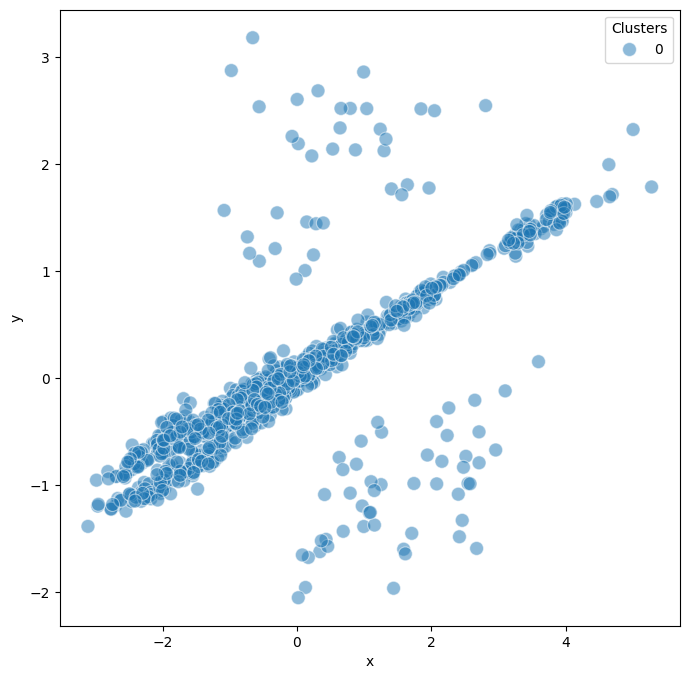

In [19]:
model.trajectory.calculate_kmean_cluster(n_cluster= 1, random_state = 12345)
model.trajectory.plot_MDS(plot_cluster=True, fig_size = (8,8), s =100)